# Data Preprocessing
This is the second notebook for robust credit risk assessment in P2P lending in context of adversarial learning, and it focuses on data preprocessing.

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Loading the Dataset
We will load the data from a CSV file, and specify the data types for some columns to avoid warnings.

In [2]:
df = pd.read_csv(
    'data/LoanData.csv',
    dtype={

        'CreditScoreEsEquifaxRisk': 'category',
        'CreditScoreFiAsiakasTietoRiskGrade': 'category',
        'ActiveLateLastPaymentCategory': 'category',
        'LoanCancelled': 'boolean',
        'ContractEndDate': 'string',
        'DefaultDate': 'string',
    },
)
df['ContractEndDate'] = pd.to_datetime(df['ContractEndDate'],format='ISO8601')
df['DefaultDate'] = pd.to_datetime(df['DefaultDate'],format='ISO8601')
df['LoanDate'] = pd.to_datetime(df['LoanDate'], format='ISO8601')

df.head()

,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,...,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory,LoanCancelled,PreviousEarlyRepaymentsBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,3015853,2022-09-09 12:27:01,2022-09-09 15:27:01,11.0,0.0,88.0,False,2022-09-09 15:15:03,2022-09-09,...,NaN,2024-05-27,6.0,23.0,2023-11-30,NaN,NaN,NaN,<NA>,NaN
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,3743447,2023-05-19 11:04:33,2023-05-19 14:04:33,0.0,0.0,0.0,False,2023-05-19 14:03:54,2023-05-19,...,NaN,2024-05-27,11.0,120.0,2023-07-20,NaN,NaN,91-120,<NA>,NaN
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,4335414,2024-02-03 14:43:32,2024-02-03 16:43:32,0.0,0.0,0.0,False,2024-02-03 16:41:51,2024-02-03,...,NaN,2024-07-08,2.0,12.0,2024-05-12,NaN,NaN,NaN,<NA>,NaN
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970.0,1150.0,5.0,False,2016-03-17 12:39:22,2016-03-23,...,2020-01-27,NaN,NaN,NaN,NaN,0.0,82.76,180+,<NA>,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,4043783,2023-09-26 12:14:12,2023-09-26 15:14:12,0.0,0.0,0.0,False,2023-09-26 15:13:07,2023-09-26,...,NaN,2024-06-04,9.0,108.0,NaN,NaN,NaN,16-30,<NA>,NaN


## Defining the Target Variable
Our goal is to predict credit risk assessment, to do so, we shall predict loan default. Based on the specification, the `DefaultDate` column indicates the date of default. If the date is missing (NaT), it has not (or has not yet) defaulted. We will create a binary target variable, `is_default`, from this column.

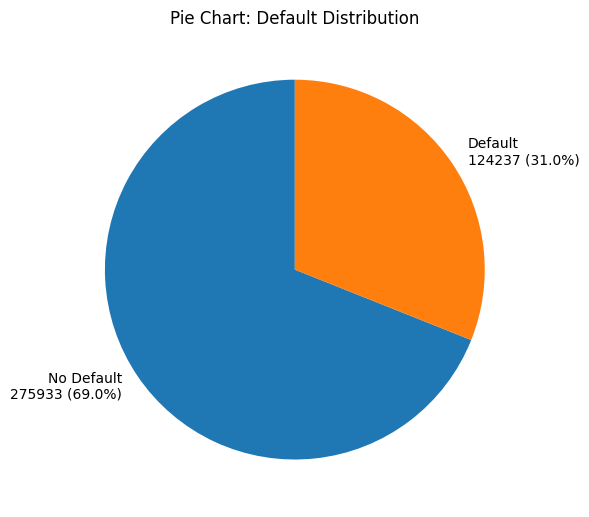

In [3]:
# Create the target variable
df['is_default'] = np.where(df['DefaultDate'].notnull(), 1, 0)

# Count and percentage
counts = df['is_default'].value_counts()
percentages = counts / counts.sum() * 100

# Create labels with percentage and count
labels = [
    f"{'No Default' if idx == 0 else 'Default'}\n{count} ({pct:.1f}%)"
    for idx, count, pct in zip(counts.index, counts.values, percentages.values)
]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=labels,
    startangle=90,
)
plt.title('Pie Chart: Default Distribution')
plt.tight_layout()
plt.show()

## Selecting Features
Some features might not be appropriate for further analysis, including features that:

- Leak information about the future.
- Are unique identifiers.
- Are explicitly marked as obsolote by Bondora.
- Are outputs from Bondora's own risk assessment system.

As there are more features that do not adhere to these criteria that do, we will define a list of features to keep, rather than specifying which to drop. We will only keep features that are known pre-approval or at the exact moment of approval of the loan.

In [4]:
demographic_features = [
    'Age',
    'Gender',
    'Education',
    'EmploymentDurationCurrentEmployer',
    'NewCreditCustomer'
]

loan_application_features = [
    'AppliedAmount',
    'LoanDuration',
    'VerificationType',
    'ApplicationSignedHour',
    'ApplicationSignedWeekday',
    'MonthlyPaymentDay'
]

financial_health_features = [
    'ExistingLiabilities',
    'RefinanceLiabilities',
    'LiabilitiesTotal'
]

previous_loan_features = [
    'NoOfPreviousLoansBeforeLoan',
    'AmountOfPreviousLoansBeforeLoan',
    'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsCountBeforeLoan'
]



target_col = ['is_default']

cols_to_keep = (
    demographic_features +
    loan_application_features +
    financial_health_features +
    previous_loan_features +
    ['LoanDate'] + # Kept only for splitting the data later
    target_col
)

# external_credit_scores = [
#     'CreditScoreEsEquifaxRisk',
#     'CreditScoreFiAsiakasTietoRiskGrade',
#     'CreditScoreEeMini',
#     'CreditScoreEsMicroL'
# ]

df_cleaned = df[cols_to_keep].copy()

### Interpretation

Important to note is that a survey with domain experts has been conducted prior to this work. From this survey, certain features were described as very important (5), important (4), and categories that indicated less importance. These features are as follows:

- Ranked 5 (very important):
    - CreditScoreEsEquifaxRisk, DefaultDate, InterestRecovery, EAD1, EAD2, CreditScoreEeMini, InterestAndPenaltyBalance, CreditScoreFiAsiakasTietoRiskGrade, RecoveryStage, CreditScoreEsMicroL, Rating, ExpectedReturn, LossGivenDefault, ProbabilityOfDefault, Amount, AppliedAmount, Interest, LoanDuration, NewCreditCustomer
- Ranked 4 (important):
    - HomeOwnershipType, DebtToIncome, IncomeFromChildSupport, IncomeFromFamilyAllowance, IncomeFromLeavePay, IncomeFromPension, IncomeFromPrincipalEmployer, IncomeFromSocialWelfare, IncomeOther, IncomeTotal, LoanCancelled, PreviousEarlyRepaymentsBeforeLoan, GracePeriodEnd, GracePeriodStart, InterestAndPenaltyDebtServicingCost, PrincipalDebtServicingCost, PrincipalWriteOffs, ReScheduledOn, ActiveLateCategory, WorseLateCategory, PrincipalOverdueBySchedule, EmploymentDurationCurrentEmployer, ExistingLiabilities, LiabilitiesTotal, PrincipalBalance, RefinanceLiabilities

Considering the criteria above, not all features that were ranked as very important or important are included in the dataset.

## Dropping Obsolete Features (Bondora)
In order to ensure that we do not use features that are marked as obsolote by Bondora, we will drop the columns that are marked as such in the specification. (sanity check)

In [5]:
specification = pd.read_csv('data/public_dataset_item.csv')

col_name_col = None
info_col = None

for col in specification.columns:
    if 'name' in col.lower():
        col_name_col = col
    if 'info' in col.lower():
        info_col = col

if col_name_col and info_col:
    obsolete_features = specification[
        specification[info_col].str.contains('Obsolete', na=False)
    ][col_name_col].tolist()

    features_to_drop = [col for col in obsolete_features if col in df_cleaned.columns]
    if features_to_drop:
        df_cleaned = df_cleaned.drop(columns=features_to_drop, errors='ignore')
        print(f"Dropped obsolete features: {features_to_drop}")
    else:
        print("No obsolete features dropped.")
else:
    print("Expected columns not found in specification. Skipping drop.")

No obsolete features dropped.


## Handling Missing Values

In [6]:
def missing_summary(df):
    """Returns a summary of missing values in the DataFrame."""
    missing_count = df.isnull().sum()
    missing_pct = 100 * missing_count / len(df)
    return pd.DataFrame({
        'missing_count': missing_count,
        'missing_pct': missing_pct
    }).loc[missing_count > 0].sort_values(by='missing_pct', ascending=False)

missing_summary(df_cleaned)

,missing_count,missing_pct
PreviousRepaymentsBeforeLoan,152193,38.032086
EmploymentDurationCurrentEmployer,13894,3.472024
PreviousEarlyRepaymentsCountBeforeLoan,83,0.020741
NoOfPreviousLoansBeforeLoan,82,0.020491
AmountOfPreviousLoansBeforeLoan,82,0.020491
Education,50,0.012495
VerificationType,50,0.012495
Gender,45,0.011245


In [7]:
# Flag and fill previous‐loan features
prev_cols = [
    'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsCountBeforeLoan',
    'NoOfPreviousLoansBeforeLoan',
    'AmountOfPreviousLoansBeforeLoan'
]
for col in prev_cols:
    df_cleaned[f'{col}_missing'] = df_cleaned[col].isna().astype(int)
    df_cleaned[col] = df_cleaned[col].fillna(0)

# Treat missing employment duration as its own category
df_cleaned['EmploymentDurationCurrentEmployer'] = (
    df_cleaned['EmploymentDurationCurrentEmployer']
    .fillna('Unknown')
    .astype('category')
)

# Small gaps in Education, Gender, VerificationType, drop the rows where these are missing
if df_cleaned['Education'].isnull().any():
    df_cleaned = df_cleaned.dropna(subset=['Education'])

missing_summary(df_cleaned)

,missing_count,missing_pct


### Interpretation

Most missingness falls are values that a structurally absent; values that are absent because the information never exists for some customers (e.g., previous-loan count for first-time borrowers). → We add a binary “_missing” flag and set the numeric field to 0. This preserves the signal that something was missing while keeping the feature numeric.

## Checking each remaining column
We will check each remaining column to ensure that it is appropriate for further analysis. This includes checking the data types, unique values, and any potential issues.

In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400120 entries, 0 to 400169
Data columns (total 24 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   Age                                             400120 non-null  int64         
 1   Gender                                          400120 non-null  float64       
 2   Education                                       400120 non-null  float64       
 3   EmploymentDurationCurrentEmployer               400120 non-null  category      
 4   NewCreditCustomer                               400120 non-null  bool          
 5   AppliedAmount                                   400120 non-null  float64       
 6   LoanDuration                                    400120 non-null  int64         
 7   VerificationType                                400120 non-null  float64       
 8   ApplicationSignedHour                  

In [9]:
def inspector(column_name):
    """Inspect a column in the DataFrame."""
    col = df_cleaned[column_name]
    print(f"Column: {column_name}")
    print(f"Data type: {col.dtype}")
    print(f"All unique values: {col.unique()}")
    print(f"Sample values: {col.sample().values}")
    print(f"Missing values: {col.isnull().sum()}")

In [10]:
# map_fi = {str(i): i for i in range(1, 9)}
# map_fi.update({
#     'RL0': 9,  'RL1': 10, 'RL2': 11, 'RL3': 12, 'RL4': 13, 'RL5': 14,
# })

# df_cleaned['CreditScoreFiAsiakasTietoRiskGrade_num'] = (
#     df_cleaned['CreditScoreFiAsiakasTietoRiskGrade']
#     .map(map_fi)
#     .astype('float')
# )

# df_cleaned['CreditScoreFiAsiakasTietoRiskGrade_missing'] = (
#     df_cleaned['CreditScoreFiAsiakasTietoRiskGrade_num'].isna().astype('int')
# )

In [11]:
# df_cleaned['CreditScoreEeMini_num'] = df_cleaned['CreditScoreEeMini']

# df_cleaned['CreditScoreEeMini_missing'] = (
#     df_cleaned['CreditScoreEeMini_num'].isna().astype('int')
# )

In [12]:
df_cleaned['Gender'] = df_cleaned['Gender'].astype('category')

In [13]:
df_cleaned['Education'] = df_cleaned['Education'].astype('category').cat.reorder_categories([0.0,1.0,2.0,3.0,4.0,5.0,-1.0], ordered=True)

In [14]:
df_cleaned['VerificationType'] = df_cleaned['VerificationType'].astype('category')

In [15]:
df_cleaned['ApplicationSignedWeekday'] = df_cleaned['ApplicationSignedWeekday'].astype('category')

In [16]:
df_cleaned['is_default'] = df_cleaned['is_default'].astype(bool)

In [17]:
missing_cols = [c for c in df_cleaned.columns if c.endswith('_missing')]
df_cleaned[missing_cols] = df_cleaned[missing_cols].astype(bool)

In [18]:
df_cleaned['ApplicationSignedHour'] = df_cleaned['ApplicationSignedHour'].astype('category')


In [19]:
df_cleaned['MonthlyPaymentDay'] = df_cleaned['MonthlyPaymentDay'].astype('category')

In [20]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400120 entries, 0 to 400169
Data columns (total 24 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   Age                                             400120 non-null  int64         
 1   Gender                                          400120 non-null  category      
 2   Education                                       400120 non-null  category      
 3   EmploymentDurationCurrentEmployer               400120 non-null  category      
 4   NewCreditCustomer                               400120 non-null  bool          
 5   AppliedAmount                                   400120 non-null  float64       
 6   LoanDuration                                    400120 non-null  int64         
 7   VerificationType                                400120 non-null  category      
 8   ApplicationSignedHour                  

## Feature Engineering
Feature engineering to potentially improve model performance.

In [21]:
# Repayment rate -> the ratio of previous repayments to the number of previous loans
df_cleaned['RepaymentRate'] = (
    df_cleaned['PreviousRepaymentsBeforeLoan']
    / df_cleaned['NoOfPreviousLoansBeforeLoan'].replace(0, np.nan)
).fillna(0)

## Splitting the Data
Before proceeding with one-hot encoding and feature scaling, we will split the dataset into training and test sets. This ensures that preprocessing steps are fitted only on the training data, preventing data leakage.

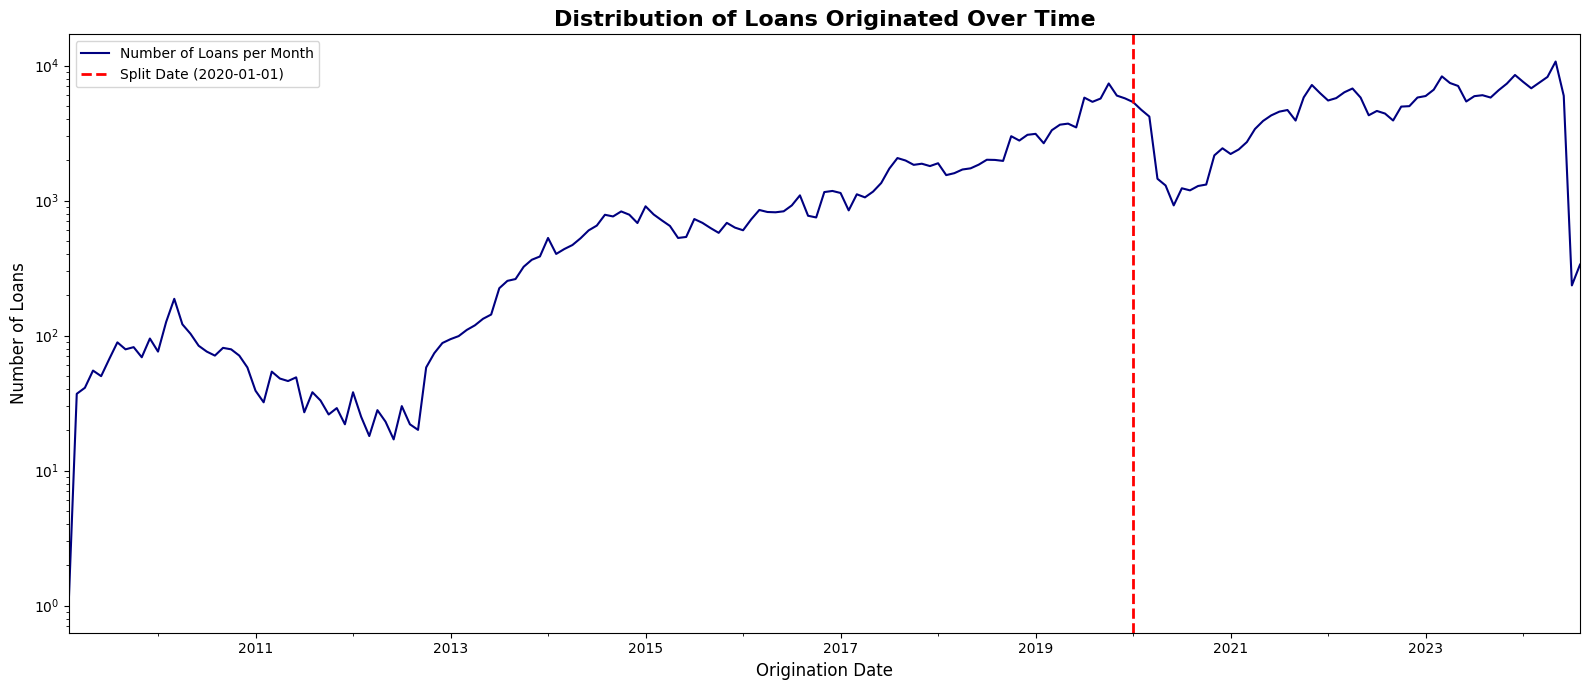

In [22]:
# Visualizing the LoanDate column to understand the distribution of the data over time
loans_by_month = df_cleaned['LoanDate'].dt.to_period('M').value_counts().sort_index()
fig, ax = plt.subplots(figsize=(16, 7))
loans_by_month.plot(kind='line', ax=ax, color='navy', label='Number of Loans per Month')

split_date = pd.to_datetime('2020-01-01') # Note that covid started around this time!
ax.axvline(
    x=split_date.to_period('M'),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Split Date ({split_date.date()})'
)

ax.set_title('Distribution of Loans Originated Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Origination Date', fontsize=12)
ax.set_ylabel('Number of Loans', fontsize=12)
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [23]:
pre_df = df_cleaned[df_cleaned['LoanDate'] < split_date].copy()

# Drop LoanDate so it isn’t fed to the model
pre_df = pre_df.drop(columns=['LoanDate'])


train_df, temp_df = train_test_split(
    pre_df, test_size=0.30, random_state=0, shuffle=False
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=0, shuffle=False
)


X_train, y_train = train_df.drop(columns=['is_default']), train_df['is_default']
X_val,   y_val   = val_df.drop(columns=['is_default']),  val_df['is_default']
X_test,  y_test  = test_df.drop(columns=['is_default']), test_df['is_default']


split_folder = os.path.join('ml', 'NoTransformations')
os.makedirs(split_folder, exist_ok=True)

X_train.to_csv(os.path.join(split_folder, 'X_train.csv'), index=False)
X_val.to_csv(  os.path.join(split_folder, 'X_val.csv'),   index=False)
X_test.to_csv( os.path.join(split_folder, 'X_test.csv'),  index=False)
y_train.to_csv(os.path.join(split_folder, 'y_train.csv'), index=False)
y_val.to_csv(  os.path.join(split_folder, 'y_val.csv'),   index=False)
y_test.to_csv( os.path.join(split_folder, 'y_test.csv'),  index=False)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train target mean: {y_train.mean():.3f}, Validation target mean: {y_val.mean():.3f}, Test target mean: {y_test.mean():.3f}")

Train shape: (91057, 23), Validation shape: (19512, 23), Test shape: (19513, 23)
Train target mean: 0.562, Validation target mean: 0.585, Test target mean: 0.539


## Transforming and Encoding
A neural network requires numerical input, so we will apply feature scaling and one-hot encoding to the dataset. We will use `StandardScaler` for numerical features and `OneHotEncoder` for categorical features. The `ColumnTransformer` will help us apply these transformations selectively to the appropriate columns.

In [24]:
# columns
num_cols = X_train.select_dtypes(include=["number"], exclude=["bool"]).columns
bool_cols = X_train.select_dtypes(include=["bool"]).columns
cat_cols  = X_train.select_dtypes(include=["category"]).columns.union(bool_cols)

# pipeline
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

# fit & transform
X_train_tf = preproc.fit_transform(X_train)
X_val_tf   = preproc.transform(X_val)
X_test_tf  = preproc.transform(X_test)

# output directory
out = "ml/StandardScalerOneHotEncoder"
os.makedirs(out, exist_ok=True)

# feature names
if hasattr(preproc, "get_feature_names_out"):
    feat_names = preproc.get_feature_names_out()
else:
    feat_names = [f"f{i}" for i in range(X_train_tf.shape[1])]

# create DataFrames
df_X_train = pd.DataFrame(X_train_tf, columns=feat_names)
df_X_val   = pd.DataFrame(X_val_tf,   columns=feat_names)
df_X_test  = pd.DataFrame(X_test_tf,  columns=feat_names)

# save transformed features
df_X_train.to_csv(f"{out}/X_train.csv", index=False)
df_X_val.to_csv(f"{out}/X_val.csv",     index=False)
df_X_test.to_csv(f"{out}/X_test.csv",   index=False)

# save targets
y_train.to_frame("is_default").to_csv(f"{out}/y_train.csv", index=False)
y_val.to_frame("is_default").to_csv(f"{out}/y_val.csv",     index=False)
y_test.to_frame("is_default").to_csv(f"{out}/y_test.csv",   index=False)

In [25]:
# Inspect the transformed data
df_X_train

,num__Age,num__AppliedAmount,num__LoanDuration,num__ExistingLiabilities,num__RefinanceLiabilities,num__LiabilitiesTotal,num__NoOfPreviousLoansBeforeLoan,num__AmountOfPreviousLoansBeforeLoan,num__PreviousRepaymentsBeforeLoan,num__PreviousEarlyRepaymentsCountBeforeLoan,...,cat__NoOfPreviousLoansBeforeLoan_missing_True,cat__PreviousEarlyRepaymentsCountBeforeLoan_missing_False,cat__PreviousEarlyRepaymentsCountBeforeLoan_missing_True,cat__PreviousRepaymentsBeforeLoan_missing_False,cat__PreviousRepaymentsBeforeLoan_missing_True,cat__VerificationType_0.0,cat__VerificationType_1.0,cat__VerificationType_2.0,cat__VerificationType_3.0,cat__VerificationType_4.0
0,1.029116,-0.232998,0.966940,1.208096,5.352746,-0.052740,-0.213196,-0.532666,-0.068691,-0.212844,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.784263,0.120316,0.966940,0.088791,-0.252262,0.143968,-0.213196,-0.228038,-0.142711,2.423660,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.294555,3.201211,0.966940,0.928270,2.550242,0.275872,-0.653001,-0.649830,-0.368931,-0.212844,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.131320,-0.485365,0.966940,-0.750688,-0.252262,-0.158458,-0.653001,-0.649830,-0.368931,2.423660,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.521623,-0.447005,0.208163,0.368617,1.616074,0.303262,-0.653001,-0.649830,-0.368931,-0.212844,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91052,-1.337801,0.625050,0.966940,-0.750688,-0.252262,-0.181936,-0.653001,-0.649830,-0.368931,-0.212844,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
91053,1.355587,-0.232998,-0.550614,-1.030515,-0.252262,-0.432360,-0.653001,-0.649830,-0.368931,-0.212844,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
91054,0.784263,1.398302,0.966940,-0.470862,-0.252262,-0.311624,0.226609,0.469090,-0.207072,-0.212844,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
91055,0.457791,-0.576217,0.966940,0.088791,-0.252262,-0.140545,0.666414,0.219530,-0.213174,-0.212844,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
